# 1. Data preparation

## 1.1 Import library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import scipy.stats
import seaborn as sns
import missingno as msno

## 1.2 Import Data

In [54]:
# loan data
loans = pd.read_csv("./Data/Credit_Card.csv")
loans.drop(columns=loans.columns[0],inplace=True)

## 1.3 Explore Data

In [55]:
loans.head()

,ID,gender,car,realty,children_count,income_amount,income_type,education_type,family_status,housing_type,mobile,work_phone,phone,email,occupation_type,family_members,status,age,working_yr
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0.0,32,12
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,0.0,32,12
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0.0,58,3
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.0,52,8
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0.0,52,8


In [15]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21410 entries, 0 to 21409
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               21410 non-null  int64  
 1   gender           21410 non-null  object 
 2   car              21410 non-null  object 
 3   realty           21410 non-null  object 
 4   children_count   21410 non-null  int64  
 5   income_amount    21410 non-null  float64
 6   income_type      21410 non-null  object 
 7   education_type   21410 non-null  object 
 8   family_status    21410 non-null  object 
 9   housing_type     21410 non-null  object 
 10  mobile           21410 non-null  int64  
 11  work_phone       21410 non-null  int64  
 12  phone            21410 non-null  int64  
 13  email            21410 non-null  int64  
 14  occupation_type  14831 non-null  object 
 15  family_members   21410 non-null  float64
 16  status           21410 non-null  float64
 17  age         

# 2 Pre-processing

## 2.1 Drop duplication

In [56]:
loans.drop_duplicates(inplace = True)
loans.index = range(loans.shape[0])

## 2.2 Missing values


When encountering a missing data, to determine the type of missing data is important, In generally, there are 3 common mechanisms:

* Structural deficiencies in the data
* Random occurrences - MCAR and MAR
* Specific cause -  NMAR.

### <strong> 2.2.1 Structural deficiencies </strong>
Structurally missing data is data that is missing for a logical reason. In other words, it is data that is missing because it should not exist. For example, many observations have missing values for occupation. This is because these people dont have job. 

In this situation, <strong> encoding missingness </strong> is a good choice. In other words,a better recording for the occupation might be to <strong>replace with “None” </strong> 

### <strong>  2.2.2 MCAR and MAR </strong>
For random occurrences, there two categories:
* Missing completetely at random(MCAR): the missing values are independent of the data
* Missing at Random (MAR): the missing values are dependent on oberved data.  

There is a example for MAR. 
| ID       |  gender   |  Age        | income    |
|----------| ----------| ----------  | ----------| 
| 1        | Male      |  Under 30   |   Low     | 
| 2        | Female    |  Under 30   |   Low     |
| 3        | Female    |  30 or more |   High    |
| 4        | Female    |  30 or more |           |
| 5        | Female    |  30 or More |   High    | 

For ID 4,we can predict the value based on the other data, so she has more probability to have a high income. In the practice, we can use <strong>imputation method</strong> , like K-Nearest Neighbors,Random Forest, and so on, or other algorithms specifically designed for missing values. 

But data with MCAR, we cannot find any pattern. If the deletion of data less likely cause bias, the missing values can be extricated from the data  

### <strong>  2.2.3 NMAR  </strong>
The missing data caused by specific cause also call not missing at random (NMAR). For example, Take the income as an example. clients with high income more likely provide income statement in order to obtain higher credit limits. In this situation, we can assume that clients with missing values in income have lower salary. 

Reference:  
[Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/index.html)

[What are the Different Types of Missing Data?](https://www.displayr.com/different-types-of-missing-data/)

occupation_type    0.307286
dtype: float64


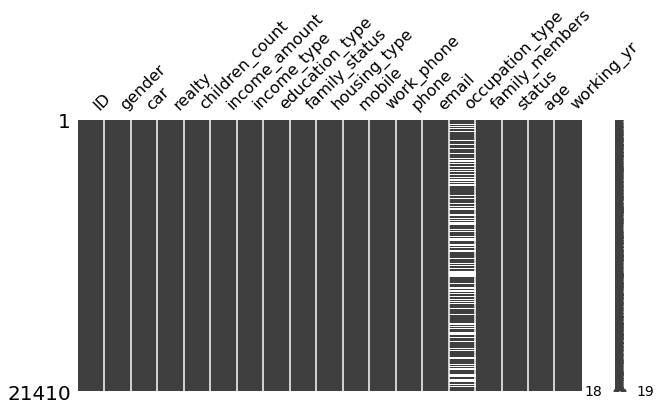

In [57]:
# check factors with missing values
print(loans.isnull().mean()[loans.isnull().mean() > 0])

# visualizing the loaction of the missing data
msno.matrix(loans,figsize=(10,5))
plt.show()

There is only one feature with missing values which is over 30% . In order to understand the missing data, communicating with data collector is critical. But This dataset come from Kaggle. So according to my own experience, this is structual miising data. 

In [58]:
print(loans["occupation_type"].value_counts(dropna = False))

NaN                      6579
Laborers                 3612
Core staff               2156
Sales staff              1939
Managers                 1858
Drivers                  1305
High skill tech staff     901
Accountants               753
Medicine staff            729
Cooking staff             374
Security staff            336
Cleaning staff            312
Private service staff     182
Low-skill Laborers        100
Secretaries                87
Waiters/barmen staff       74
HR staff                   45
IT staff                   40
Realty agents              28
Name: occupation_type, dtype: int64


Since the occupation tpye is a categorical feature, we can directly switch the missing value to the string "Nan" as a category. 

In [59]:
# ecode missing data
loans.replace(np.nan,"Nan",inplace=True)

## 2.3 Outlier

<strong> A) Univariate Outliers:  </strong>  
<strong> 1) Interquartile Range Method </strong>   
First setp is to calculate first quartile(Q1), median, and third quartile(Q3). The IQR is the difference between Q3 and Q1. 
The outliers are 

$$< Q1 − 1.5 \times IQR$$
$$> Q3 + 1.5 \times IQR $$

<strong> 2) Standard Deviation Method </strong>   
If distribution of data is approximately nomrl, then 68% of the data values lie within one standard deviation of the mean and about 95% are within two standard deviations, and about 99.7% lie within three standard deviations. In general, 3 $\sigma$ is used to identify outliers. 

$$M< \mu - 3\sigma$$
$$M> \mu + 3\sigma$$

<strong>3) Z-Score method </strong>  
It is similar to Second method. This technique assumes a Gaussian distribution of the data. The outliers are the data points that are in the tails of the distribution and therefore far from the mean.

$$Z-core = \frac{(x - \mu)}{\sigma}$$
$$ \lvert Z\_score \lvert > Zthr $$

<strong> 4) Isolation Forest </strong>  

How many splits does take simple point to the isolated 
1. randomly selecting a point to isolate
2. randomly selecting a split point between the max and min 
   * If the chosen value keeps the point above, switch the minimum of the range of the feature to the value.
   * If the chosen value keeps the point below, switch the maximum of the range of the feature to the value
3. repeat 2 until the point isolated
4. Count how many time repeat step 2, which is isolation number

The isolation number of outlier significantly less than that of non-outlier. 

<strong> B) Mulitivariate Outliers: </strong>  
<strong> 1) DBSCAN </strong> 
   
DBSCAN is (Density-Based Spatial Clustering of Applications with Noise). The main idea behind that is one concept, two hyperparameters, and three types of points.  

One concept: DBSCAN groups together points that are close to each other based on a distance measurement and a minimum number of points.

Two hyperparameters:
* <strong> eps </strong>: The distance that specifies the neighborhoods  
* <strong> minPts </strong> : Minimum number of data points to define a cluster  

Three types of point:  
* <strong> Core point </strong>: A point is a core point if there are at least minPts number of points  in its surrounding area with radius eps.
* <strong> Border point</strong>: A point is a border point if it is reachable from a core point and there are less than minPts number of points within its surrounding area.
* <strong> Outlier</strong>: A point is an outlier if it is not a core point and not reachable from any core points.  

<div align=center> <img src="https://miro.medium.com/max/627/1*yT96veo7Zb5QeswV7Vr7YQ.png" width = "20%"> </div> 


In [60]:
loans.loc[:,loans.dtypes != 'object'].drop(columns= ["ID","status","mobile", "work_phone", "phone", "email"]).describe().T

,count,mean,std,min,25%,50%,75%,max
children_count,21410.0,0.431527,0.739196,0.0,0.0,0.0,1.0,14.0
income_amount,21410.0,189277.247922,102002.349689,27000.0,126000.0,166500.0,225000.0,1575000.0
family_members,21410.0,2.211583,0.903683,1.0,2.0,2.0,3.0,15.0
age,21410.0,43.558524,11.219676,21.0,34.0,42.0,53.0,68.0
working_yr,21410.0,-155.301261,370.650445,-1001.0,1.0,4.0,8.0,43.0


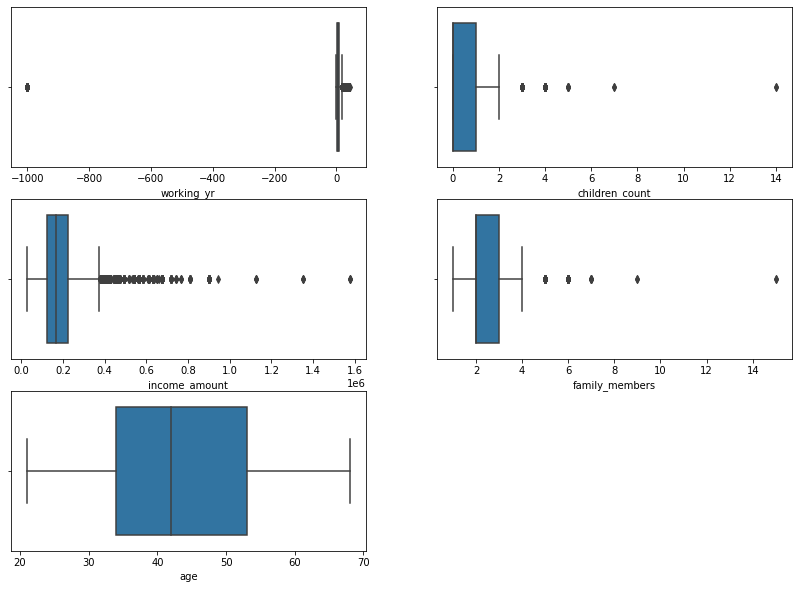

In [61]:
# Interquartile Range Method
# working_yr
plt.figure(figsize=(14,10))
ax = plt.subplot(3,2,1)
sns.boxplot(loans.working_yr)

# children_count
ax = plt.subplot(3,2,2)
sns.boxplot(loans.children_count)

# income_amount
ax = plt.subplot(3,2,3)
sns.boxplot(loans.income_amount)

# family_members
ax = plt.subplot(3,2,4)
sns.boxplot(loans.family_members)

# age
ax = plt.subplot(3,2,5)
sns.boxplot(loans.age)
plt.show()

Since we will do feature binning, the outlier is not the big issue for us. 

But there is a abnormal feature, years of working experience that include negative value, so we can delete such obervations. 

In [62]:
# number of abnormal values
print("Number of clients with years of working experience less than 0: {} ".format((loans.working_yr < 0).sum()))
print("Number of observations: {} ".format(loans.shape[0]))
print("Deletion does not cause the huge loss of obervations")

# drop the rows with negative working year
loans.drop(index = loans[loans["working_yr"] < 0]["ID"].index, inplace = True)
loans.reset_index(drop =True,inplace=True)

Number of clients with years of working experience less than 0: 3449 
Number of observations: 21410 
Deletion does not cause the huge loss of obervations


In [63]:
# check for columns with object features
for i in range((loans.dtypes == 'object').sum()):
    print("-"*50)
    print(loans.loc[:,loans.dtypes == 'object'].iloc[:,i].value_counts())

for x in ("mobile", "work_phone", "phone", "email"):
    print("-"*50)
    print(loans.loc[:,x].value_counts())
# mobile, work_phone, phone, email

--------------------------------------------------
F    11279
M     6682
Name: gender, dtype: int64
--------------------------------------------------
N    10273
Y     7688
Name: car, dtype: int64
--------------------------------------------------
Y    11434
N     6527
Name: realty, dtype: int64
--------------------------------------------------
Working                 11001
Commercial associate     5090
State servant            1844
Pensioner                  16
Student                    10
Name: income_type, dtype: int64
--------------------------------------------------
Secondary / secondary special    11629
Higher education                  5343
Incomplete higher                  820
Lower secondary                    144
Academic degree                     25
Name: education_type, dtype: int64
--------------------------------------------------
Married                 12846
Single / not married     2236
Civil marriage           1425
Separated                1063
Widow             

For mobile, it only has one value which is 1, which cannot provide us any useful information for our models, so we remove it from our dataset.  

In [64]:
loans.drop(columns = "mobile",inplace=True)

## 2.4 imbalance 

In [93]:
X = loans.drop(columns = ["status","ID"])
y = loans["status"]

0.0    17475
1.0      486
Name: status, dtype: int64
0 = No default,1= Default
--------------------------------------------------
Good Customers accounted for 97.29 % of the dataset
Bad Customers accounted for 2.71 % of the dataset



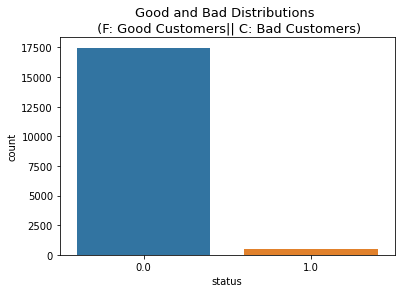

In [94]:
# number of Good and Bad Customers
print(y.value_counts())
print("0 = No default,1= Default")
print("-"*50)

# ratio of Good and Bad Customers
print('Good Customers accounted for', round(loans['status'].value_counts()[0]/len(loans['status']) * 100,2), '% of the dataset')
print('Bad Customers accounted for', round(loans['status'].value_counts()[1]/len(loans['status']) * 100,2), '% of the dataset')
print("")

# plot 
sns.countplot(loans['status'])
plt.title('Good and Bad Distributions \n (F: Good Customers|| C: Bad Customers)', fontsize=13)
plt.show()

In this sample size over the time interval, there are 17475 good customers and 486 bad customers. The bad customers accounted for approximately 2.71% of the sample size. Our goal is to be certain when the model predict correctly which customer is good or bad.

Imbalanced datasets are usually misleading about the accuracy of the model since the gap between good customers and bad customers is extremely high. If we do not randomized balanced out the good and bad customers, the algorithms will probably overfit since it will assume most of the clients are good. It will also gives us a wrong correlation between the features since the good customers dominated the sample size. By creating a balanced sub-sample which equal the amount of good and bad, we can eliminate the overfiting and helping algorithms achive better accuracy on classification results.

The SMOTE method can help us to solve such problem

In [95]:
# int
X.loc[:,["income_amount","age","working_yr"]] = X[["income_amount","age","working_yr"]].astype(int)

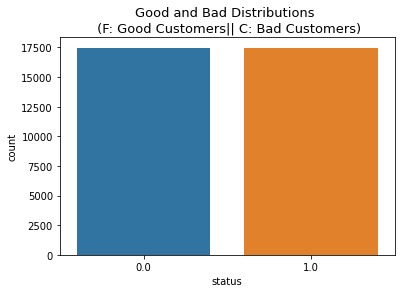

In [96]:
# deal with imbalance 
from imblearn.over_sampling import SMOTENC
smote_nc= SMOTENC(categorical_features=[0,1,2,3,5,6,7,8,9,10,11,12,13],random_state=42) 
X,y = smote_nc.fit_resample(X,y)

# plot 
sns.countplot(y)
plt.title('Good and Bad Distributions \n (F: Good Customers|| C: Bad Customers)', fontsize=13)
plt.show()

# 3 train & test split 

In [97]:
from sklearn.model_selection import train_test_split 
X = pd.DataFrame(X) 
y = pd.DataFrame(y)

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.3,random_state=420)

# data for train
model_data = pd.concat([Y_train, X_train], axis=1)
model_data.index = range(model_data.shape[0])

# data for test
test_data = pd.concat([Y_test, X_test], axis=1) 
test_data.index = range(test_data.shape[0])

# export the data 
model_data.to_csv("./Data/model_data.csv", index=False)
test_data.to_csv("./Data/test_data.csv",index=False)

# 4 Binning, WOE and IV

### Concept


WOE Binning is to create new categorical features for all numberical and categorical features, which is the most critical steps. 

Firstly, the fewer number of bins, the more information will loss. But in order to built credit scorecard, the numbers of bins should be limited. In generally, less than 10 bins is recerivable, and optimail number is 4 - 5.

In order to meature information of features after binning, Weight of Evidence(WOE) and Information Value(IV) were introduced. 

WOE is a measure of the predictive power of an independent variable in relation to the target variable. In this case, it meature power of feature to separat good and bad clients. 

$$ W O E_{i}=\ln \left(\frac{g o o d \%}{b a d \%}\right) $$

IV ranks our feature based on their relative importance, which assists with selecting important features in a predictive model.

$$I V=\sum_{i=1}^{N}(g o o d \%-b a d \%) \times W O E_{i}$$

<strong> Rules related to Information Value </strong>  

|Information Value	| Variable Predictiveness|
|------------------ | ---------------------- |
|Less than 0.02	    |Not useful for prediction|
|0.02 to 0.1	    |Weak predictive Power|
|0.1 to 0.3	        |Medium predictive Power|
|0.3 to 0.5	        |Strong predictive Power|
|>0.5	            | Suspicious Predictive Power|

Steps: 
<strong> 1) binning </strong>  
The most widely used binning algorithm is Chi-merge. Chi-merge is a process of dividing into intervals (bins) in the way that neighboring bins will differ from each other as much as possible in the ratio of “Good” and “Bad” records in them.

<strong> 2）Analysis and manual correction of binning  </strong>  
After taken 10 - 20 bins, we can oberve the relatinship between IV and number of bins tp identify the optimal number of bins. There is trade-off. And the WOE should be monotonic. 

referenc:   
[Scorecard Development Stage](https://plug-n-score.com/learning/scorecard-development-stages.htm#Binning)

[WEIGHT OF EVIDENCE (WOE) AND INFORMATION VALUE (IV) EXPLAINED](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)


In [4]:
# load the data
model_data= pd.read_csv('./Data/model_data.csv', low_memory=True)
test_data = pd.read_csv('./Data/test_data.csv', low_memory=True) 

In [51]:
df_features = model_data.drop(columns='status')
df_targets = model_data['status']

# run the second time for test data 
#df_features = test_data.drop(columns='status')
#df_targets = test_data['status']


For the binary features, we donot need to do binning

## 4.1 Preprocessing Discrete Variables - Binary Features

### Define function

In [52]:
def woe_discrete(df,discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name],good_bad_variable_df],axis =1)
    df = pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0],'n_obs','prop_bad']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_bad'] = df['prop_bad']*df['n_obs']
    df['n_good'] = (1- df['prop_bad'])*df['n_obs']
    df["prop_n_good"] = df['n_good'] / df['n_good'].sum()
    df["prop_n_bad"]= df['n_bad'] / df['n_good'].sum()
    df['WoE'] = np.log(df["prop_n_good"]/df["prop_n_bad"])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop=True)
    df["IV"]= (df["prop_n_good"]-df["prop_n_bad"])*df["WoE"]
    df["IV"] = df["IV"].sum()
    return df

In [53]:
def plot_by_woe(df_WoE,rotation_of_x_axis_labels=0):
    x = np.array(df_WoE.iloc[:,0].apply(str))
    y = df_WoE['WoE']

    plt.figure(figsize=(18,6))
    plt.plot(x,y)
    plt.plot(x,y,marker = 'o',linestyle='--',color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weigh of Eviendence')
    plt.title(str("Weight of Evidence by" + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

In [54]:
woe = pd.DataFrame()
def store_woe(df):
    woe_each= pd.DataFrame(df.iloc[:,[0,-2,-1]],columns=['Features',df.columns[0],'WoE','IV'])
    woe_each['Features'] = df.columns[0]
    woe_each.columns =['Features', 'Value','WoE','IV']
    woe_each.set_index(['Features', 'Value'],inplace=True)
    return woe_each

###  WOE Calculation

#### 4.1.1 Binary variable - phone

,car,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,N,14421,0.520630,0.589454,7508.0,6913.0,0.569112,0.618095,-0.082565,0.006993
1,Y,10044,0.478893,0.410546,4810.0,5234.0,0.430888,0.395983,0.084479,0.006993


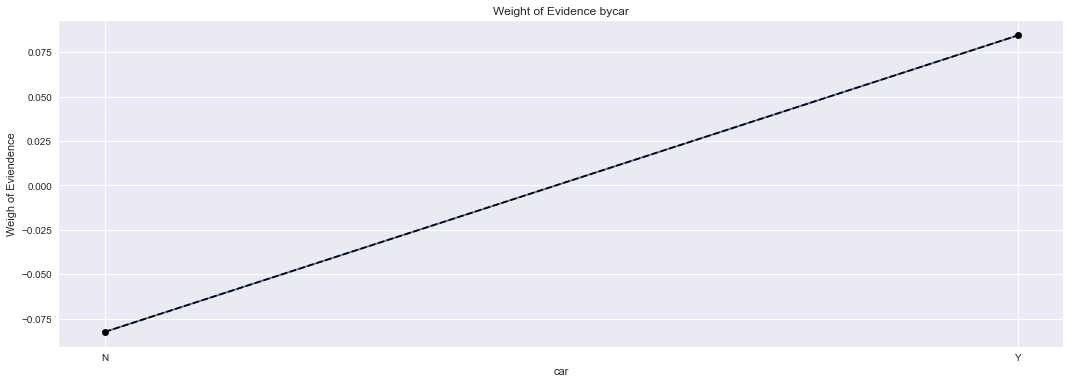

In [55]:
woe = pd.DataFrame()

# car realty work_phone	phone email
df_temp = woe_discrete(df_features,'car', df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.1.2 Binary variable - reality

,realty,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Y,15705,0.508373,0.641937,7984.0,7721.0,0.63563,0.657282,-0.033496,0.000884
1,N,8760,0.494749,0.358063,4334.0,4426.0,0.36437,0.356796,0.021005,0.000884


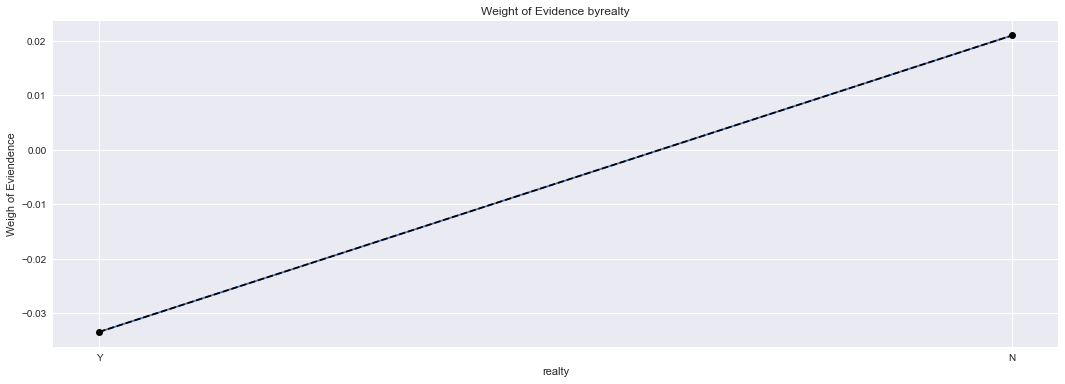

In [56]:
# reality
df_temp = woe_discrete(df_features,'realty', df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.1.3 Binary variable - work_phone

,work_phone,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,0,18005,0.511691,0.735949,9213.0,8792.0,0.7238,0.758459,-0.046773,0.003215
1,1,6460,0.480650,0.264051,3105.0,3355.0,0.2762,0.255619,0.077438,0.003215


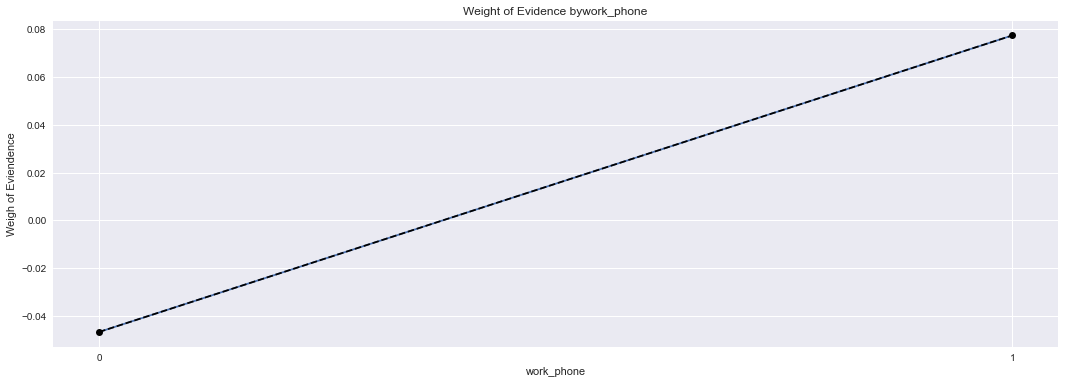

In [57]:
# work_phone
df_temp = woe_discrete(df_features,'work_phone', df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.1.4 Binary variable - phone

,phone,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,0,17340,0.509804,0.708768,8840.0,8500.0,0.699761,0.727752,-0.039221,0.001758
1,1,7125,0.488140,0.291232,3478.0,3647.0,0.300239,0.286326,0.047447,0.001758


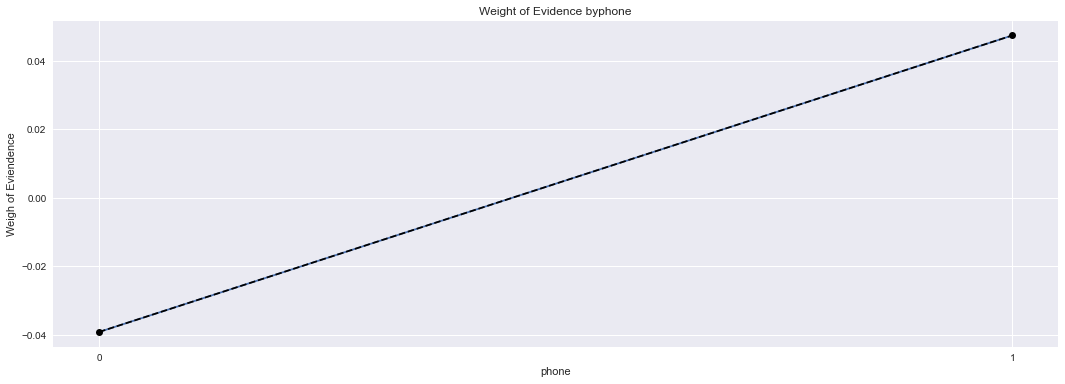

In [58]:
# phone
df_temp = woe_discrete(df_features,'phone', df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.1.5 Binary variable - email

,email,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,0,22693,0.521042,0.92757,11824.0,10869.0,0.894789,0.973409,-0.084217,0.06797
1,1,1772,0.278781,0.07243,494.0,1278.0,0.105211,0.040668,0.950516,0.06797


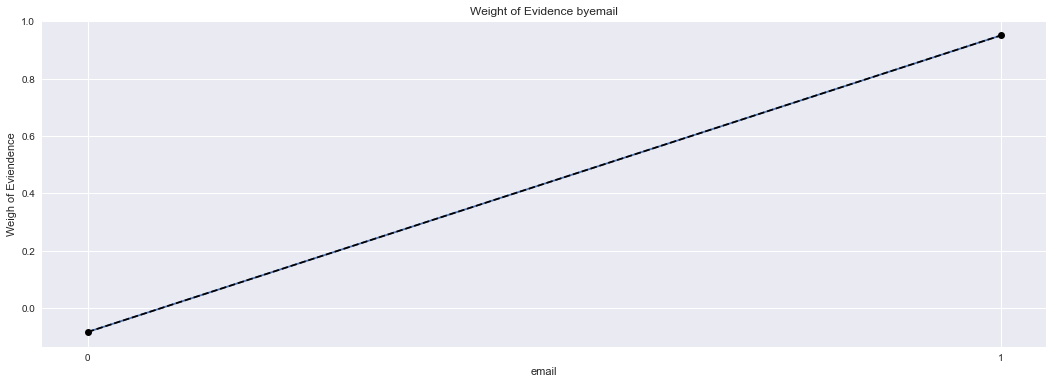

In [59]:
# email
df_temp = woe_discrete(df_features,'email', df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

## 4.2 Preprocessing Discrete Variables - Categorical Features

### WOE Calculation

#### 4.2.1 income_type

In [60]:
df_temp= woe_discrete(df_features,'income_type',df_targets)
df_temp

/Users/song/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,income_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Pensioner,43,1.000000,0.001758,43.0,0.0,0.000000,0.003540,-inf,inf
1,Working,15959,0.532051,0.652320,8491.0,7468.0,0.614802,0.699020,-0.128380,inf
2,Commercial associate,6969,0.508681,0.284856,3545.0,3424.0,0.281880,0.291842,-0.034729,inf
3,State servant,1486,0.160834,0.060740,239.0,1247.0,0.102659,0.019676,1.652032,inf
4,Student,8,0.000000,0.000327,0.0,8.0,0.000659,0.000000,inf,inf


,income_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Working,15959,0.532051,0.652320,8491.0,7468.0,0.614802,0.699020,-0.128380,0.130749
1,Commercial associate,6969,0.508681,0.284856,3545.0,3424.0,0.281880,0.291842,-0.034729,0.130749
2,Student / State servant / Pensioner,1537,0.183474,0.062824,282.0,1255.0,0.103318,0.023216,1.492984,0.130749


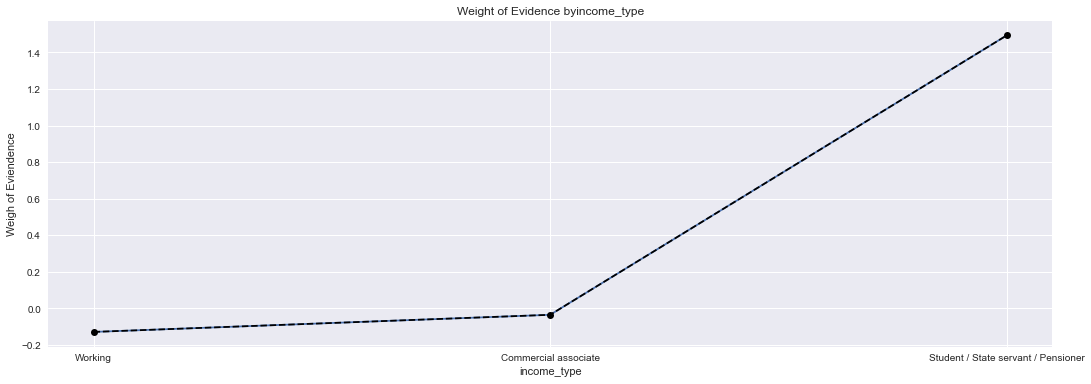

In [61]:
df_features = df_features.replace(["Student","State servant","Pensioner"],"Student / State servant / Pensioner")
df_temp= woe_discrete(df_features,'income_type',df_targets)
display(df_temp)
plot_by_woe(df_temp)

In [62]:
# store woe
woe = woe.append(store_woe(df_temp))

#### 4.2.2 education_type

,education_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Secondary / secondary special,16668,0.527958,0.681300,8800.0,7868.0,0.647732,0.724459,-0.111948,inf
1,Incomplete higher,1024,0.468750,0.041856,480.0,544.0,0.044785,0.039516,0.125163,inf
2,Higher education,6626,0.452309,0.270836,2997.0,3629.0,0.298757,0.246728,0.191345,inf
3,Lower secondary,132,0.310606,0.005395,41.0,91.0,0.007492,0.003375,0.797287,inf
4,Academic degree,15,0.000000,0.000613,0.0,15.0,0.001235,0.000000,inf,inf


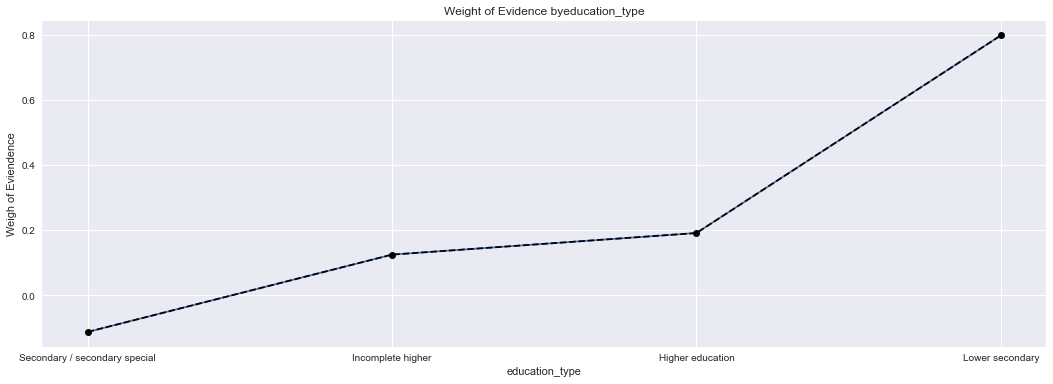

In [63]:
df_temp= woe_discrete(df_features,'education_type',df_targets)
display(df_temp)
plot_by_woe(df_temp)

,education_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Secondary / secondary special,16668,0.527958,0.6813,8800.0,7868.0,0.647732,0.724459,-0.111948,0.020858
1,others,7797,0.451199,0.3187,3518.0,4279.0,0.352268,0.289619,0.195827,0.020858


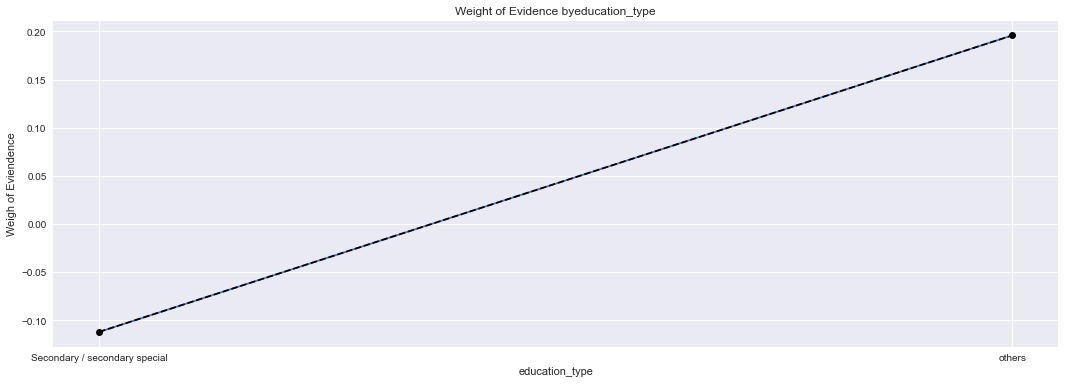

In [64]:
df_features=df_features.replace(["Incomplete higher","Higher education",'Academic degree','Lower secondary'],"others")
df_temp= woe_discrete(df_features,'education_type',df_targets)
display(df_temp)
plot_by_woe(df_temp)

In [65]:
woe = woe.append(store_woe(df_temp))

#### 4.2.3 family_status	

,family_status,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Widow,590,0.540678,0.024116,319.0,271.0,0.022310,0.026262,-0.163072,0.044225
1,Married,18130,0.521125,0.741059,9448.0,8682.0,0.714744,0.777805,-0.084551,0.044225
2,Single / not married,2904,0.487259,0.118700,1415.0,1489.0,0.122582,0.116490,0.050975,0.044225
3,Civil marriage,1859,0.467994,0.075986,870.0,989.0,0.081419,0.071623,0.128201,0.044225
4,Separated,982,0.270876,0.040139,266.0,716.0,0.058945,0.021898,0.990184,0.044225


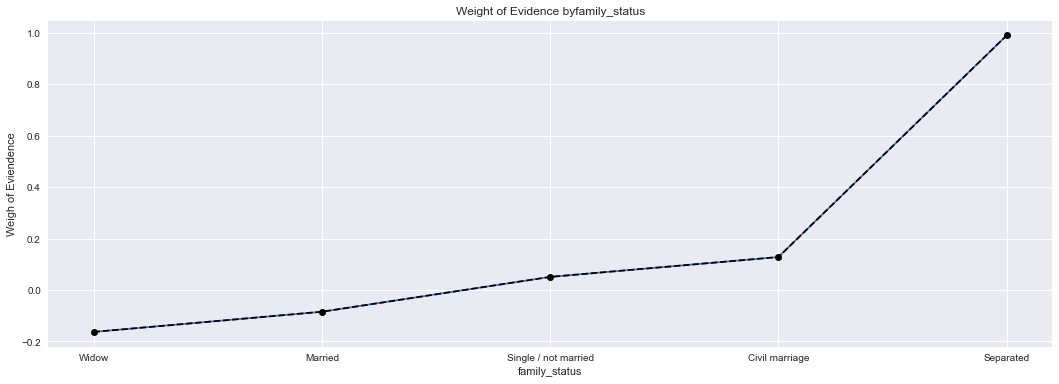

In [66]:
df_temp= woe_discrete(df_features,'family_status',df_targets)
display(df_temp)
plot_by_woe(df_temp)

,family_status,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,Widow,590,0.540678,0.024116,319.0,271.0,0.022310,0.026262,-0.163072,0.043947
1,Married,18130,0.521125,0.741059,9448.0,8682.0,0.714744,0.777805,-0.084551,0.043947
2,Single / not married / Civil marriage,4763,0.479740,0.194686,2285.0,2478.0,0.204001,0.188112,0.081086,0.043947
3,Separated,982,0.270876,0.040139,266.0,716.0,0.058945,0.021898,0.990184,0.043947


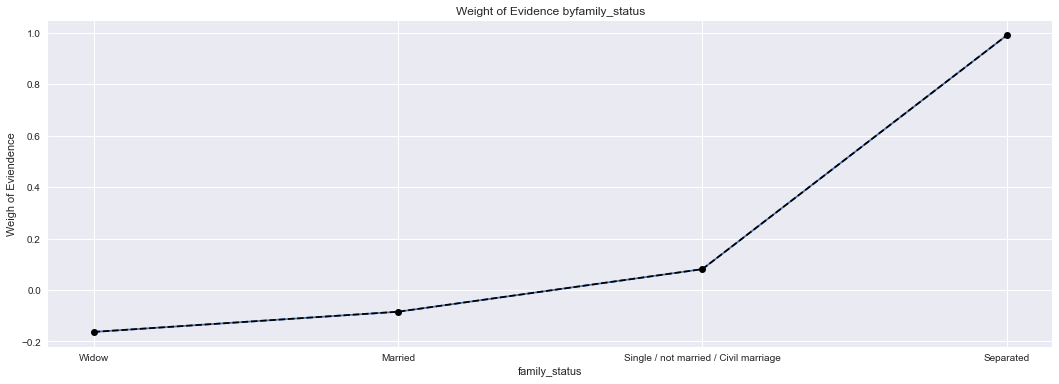

In [67]:
df_features =df_features.replace(["Single / not married","Civil marriage"],"Single / not married / Civil marriage")
df_temp= woe_discrete(df_features,'family_status',df_targets)
display(df_temp)
plot_by_woe(df_temp)

In [68]:
# store woe
woe = woe.append(store_woe(df_temp))

In [69]:
woe

WoE        IV
Features       Value                                                    
car            N                                     -0.082565  0.006993
               Y                                      0.084479  0.006993
realty         Y                                     -0.033496  0.000884
               N                                      0.021005  0.000884
work_phone     0                                     -0.046773  0.003215
               1                                      0.077438  0.003215
phone          0                                     -0.039221  0.001758
               1                                      0.047447  0.001758
email          0                                     -0.084217  0.067970
               1                                      0.950516  0.067970
income_type    Working                               -0.128380  0.130749
               Commercial associate                  -0.034729  0.130749
               Student / State servant / Pensioner    1.492984  0.130749
education_type Secondary / secondary special         -0.111948  0.020858
               others                                 0.195827  0.020858
family_status  Widow                                 -0.163072  0.043947
               Married                               -0.084551  0.043947
               Single / not married / Civil marriage  0.081086  0.043947
               Separated                              0.990184  0.043947

#### 4.2.4 housing_type

,housing_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,House / apartment,22601,0.523517,0.923810,11832.0,10769.0,0.886556,0.974068,-0.094136,0.121582
1,Office apartment,125,0.392000,0.005109,49.0,76.0,0.006257,0.004034,0.438913,0.121582
2,Municipal apartment,561,0.294118,0.022931,165.0,396.0,0.032601,0.013584,0.875469,0.121582
3,With parents,919,0.286181,0.037564,263.0,656.0,0.054005,0.021651,0.914007,0.121582
4,Rented apartment,187,0.037433,0.007644,7.0,180.0,0.014818,0.000576,3.247047,0.121582
5,Co-op apartment,72,0.027778,0.002943,2.0,70.0,0.005763,0.000165,3.555348,0.121582


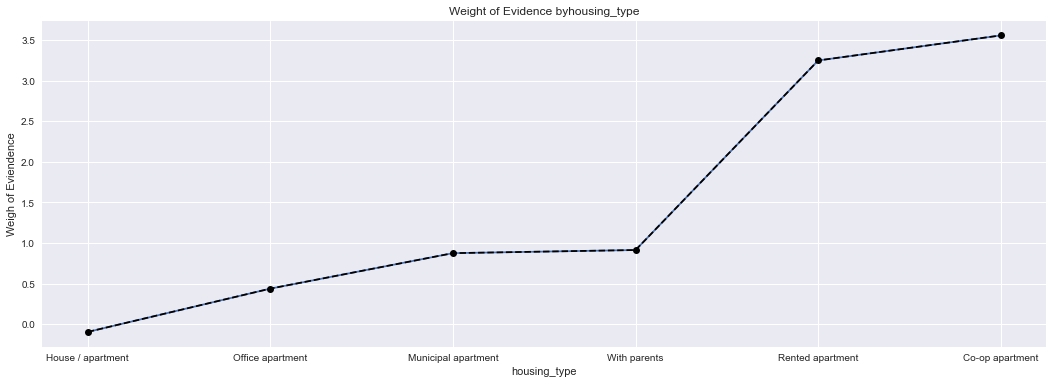

In [70]:
df_temp= woe_discrete(df_features,'housing_type',df_targets)
display(df_temp)
plot_by_woe(df_temp)

,housing_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,House / apartment,22601,0.523517,0.92381,11832.0,10769.0,0.886556,0.974068,-0.094136,0.084769
1,Other,1864,0.260730,0.07619,486.0,1378.0,0.113444,0.040010,1.042180,0.084769


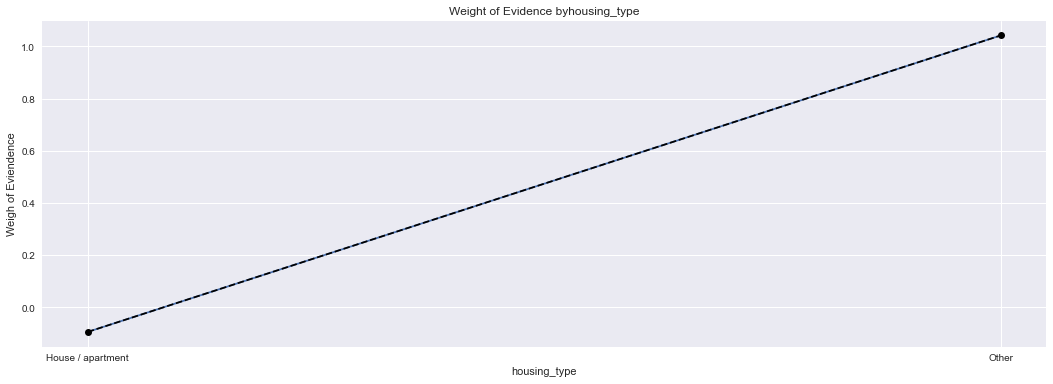

In [71]:
df_features =df_features.replace(["Office apartment","Municipal apartment","With parents","Rented apartment","Co-op apartment"],"Other")
df_temp= woe_discrete(df_features,'housing_type',df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.2.5 children_count

,children_count,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,0,16622,0.535676,0.679420,8904.0,7718.0,0.635383,0.733020,-0.142945,inf
1,3,329,0.492401,0.013448,162.0,167.0,0.013748,0.013337,0.030397,inf
2,1,5365,0.454054,0.219293,2436.0,2929.0,0.241129,0.200543,0.184304,inf
3,2,2113,0.385708,0.086368,815.0,1298.0,0.106858,0.067095,0.465392,inf
4,4,29,0.034483,0.001185,1.0,28.0,0.002305,0.000082,3.332205,inf
5,5,5,0.000000,0.000204,0.0,5.0,0.000412,0.000000,inf,inf
6,7,1,0.000000,0.000041,0.0,1.0,0.000082,0.000000,inf,inf
7,14,1,0.000000,0.000041,0.0,1.0,0.000082,0.000000,inf,inf


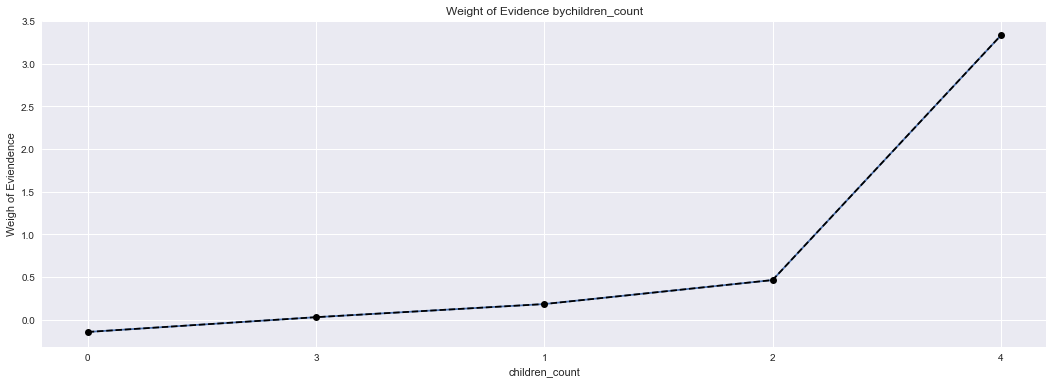

In [72]:
df_temp= woe_discrete(df_features,'children_count',df_targets)
display(df_temp)
plot_by_woe(df_temp)

,children_count,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,0,16622,0.535676,0.679420,8904.0,7718.0,0.635383,0.733020,-0.142945,0.039817
1,1,5365,0.454054,0.219293,2436.0,2929.0,0.241129,0.200543,0.184304,0.039817
2,over 2,2478,0.394673,0.101288,978.0,1500.0,0.123487,0.080514,0.427711,0.039817


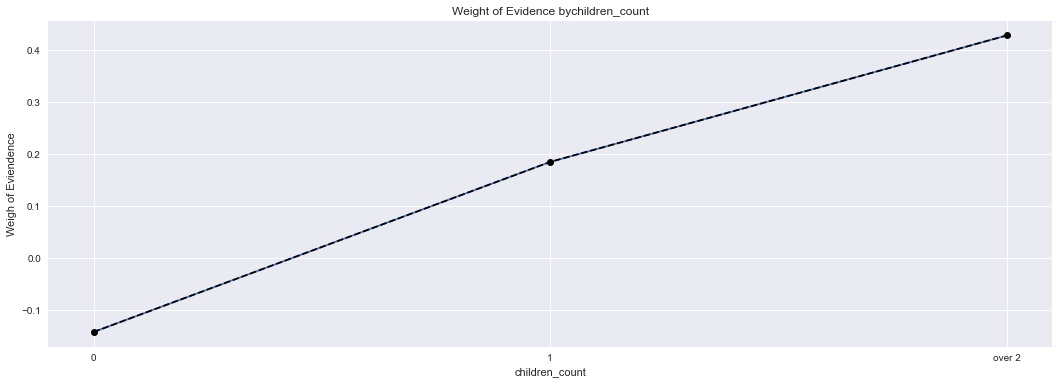

In [73]:
df_features.replace({"children_count":{2:'over 2',3:"over 2",4:"over 2",5:"over 2",7:"over 2",14:"over 2"}},inplace=True)
df_temp= woe_discrete(df_features,'children_count',df_targets)
display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.2.6 family_members

,family_members,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,2.0,13406,0.530136,0.547966,7107.0,6299.0,0.518564,0.585083,-0.120689,inf
1,5.0,342,0.517544,0.013979,177.0,165.0,0.013584,0.014571,-0.070204,inf
2,1.0,3940,0.514721,0.161046,2028.0,1912.0,0.157405,0.166955,-0.058900,inf
3,3.0,4648,0.462349,0.189986,2149.0,2499.0,0.205730,0.176916,0.150888,inf
4,4.0,2095,0.408592,0.085633,856.0,1239.0,0.102000,0.070470,0.369790,inf
5,6.0,28,0.035714,0.001144,1.0,27.0,0.002223,0.000082,3.295837,inf
6,7.0,4,0.000000,0.000163,0.0,4.0,0.000329,0.000000,inf,inf
7,9.0,1,0.000000,0.000041,0.0,1.0,0.000082,0.000000,inf,inf
8,15.0,1,0.000000,0.000041,0.0,1.0,0.000082,0.000000,inf,inf


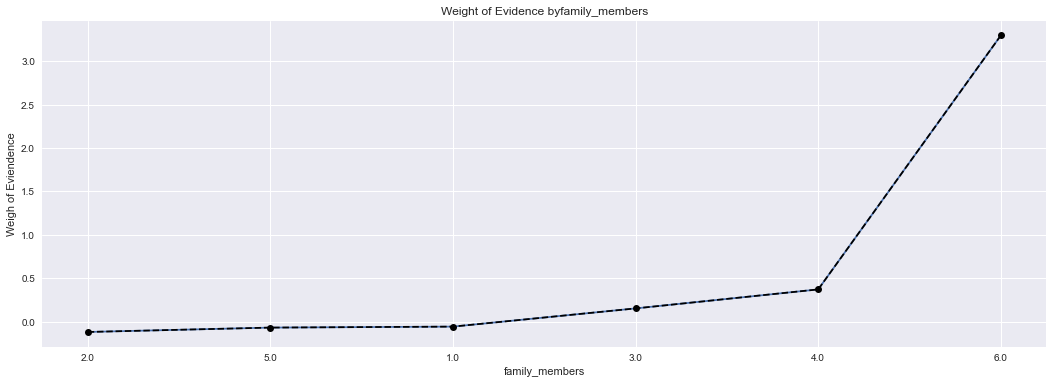

In [74]:
df_temp= woe_discrete(df_features,'family_members',df_targets)
display(df_temp)
plot_by_woe(df_temp)

,family_members,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,<= 2,17346,0.526634,0.709013,9135.0,8211.0,0.675969,0.752038,-0.106638,0.023379
1,3,4648,0.462349,0.189986,2149.0,2499.0,0.205730,0.176916,0.150888,0.023379
2,>= 4,2471,0.418454,0.101001,1034.0,1437.0,0.118301,0.085124,0.329123,0.023379


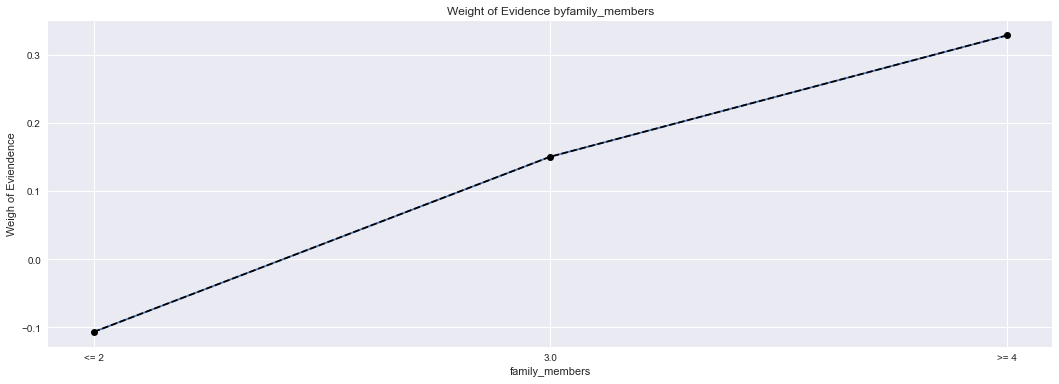

In [75]:
df_features.replace({"family_members":{2: "<= 2",1:"<= 2"}},inplace=True)
df_features.replace({"family_members":{4: ">= 4",5:">= 4",6:">= 4",7:">= 4",9:">= 4",15:">= 4",20:">= 4"}},inplace=True)
df_temp= woe_discrete(df_features,'family_members',df_targets)

display(df_temp)
plot_by_woe(df_temp)

# store woe
woe = woe.append(store_woe(df_temp))

#### 4.2.7 occupation_type

,occupation_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,IT staff,137,0.766423,0.005600,105.0,32.0,0.002634,0.008644,-1.188224,inf
1,Drivers,2621,0.664632,0.107133,1742.0,879.0,0.072364,0.143410,-0.684004,inf
2,Laborers,5513,0.555233,0.225342,3061.0,2452.0,0.201861,0.251996,-0.221838,inf
3,High skill tech staff,1351,0.539600,0.055222,729.0,622.0,0.051206,0.060015,-0.158734,inf
4,Secretaries,132,0.522727,0.005395,69.0,63.0,0.005186,0.005680,-0.090972,inf
5,Security staff,441,0.514739,0.018026,227.0,214.0,0.017618,0.018688,-0.058974,inf
6,Core staff,2891,0.505016,0.118169,1460.0,1431.0,0.117807,0.120194,-0.020063,inf
7,Managers,2449,0.481421,0.100102,1179.0,1270.0,0.104553,0.097061,0.074350,inf
8,Cooking staff,473,0.477801,0.019334,226.0,247.0,0.020334,0.018605,0.088853,inf
9,Accountants,991,0.462159,0.040507,458.0,533.0,0.043879,0.037705,0.151652,inf


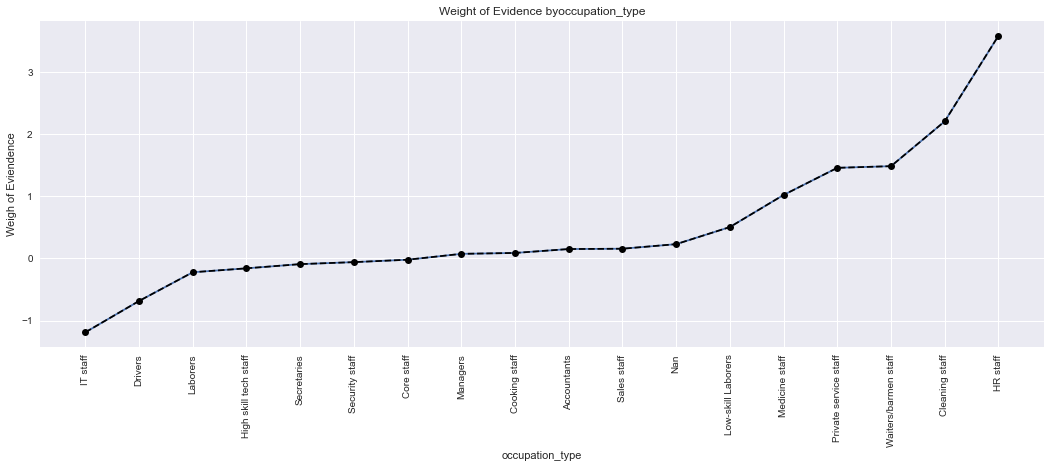

In [76]:
df_temp= woe_discrete(df_features,'occupation_type',df_targets)
display(df_temp)
plot_by_woe(df_temp,90)


,occupation_type,n_obs,prop_bad,prop_n_obs,n_bad,n_good,prop_n_good,prop_n_bad,WoE,IV
0,IT/Drivers,2758,0.669688,0.112732,1847.0,911.0,0.074998,0.152054,-0.706775,0.149623
1,Laborers,5513,0.555233,0.225342,3061.0,2452.0,0.201861,0.251996,-0.221838,0.149623
2,Sales/Accountants/Cooking/Managers/Core/Securi...,11169,0.490017,0.456530,5473.0,5696.0,0.468922,0.450564,0.039937,0.149623
3,Nan,3732,0.442658,0.152544,1652.0,2080.0,0.171236,0.136001,0.230381,0.149623
4,Realty/HR/Cleaning/Waiters/barmen/Private serv...,1293,0.220418,0.052851,285.0,1008.0,0.082983,0.023463,1.263234,0.149623


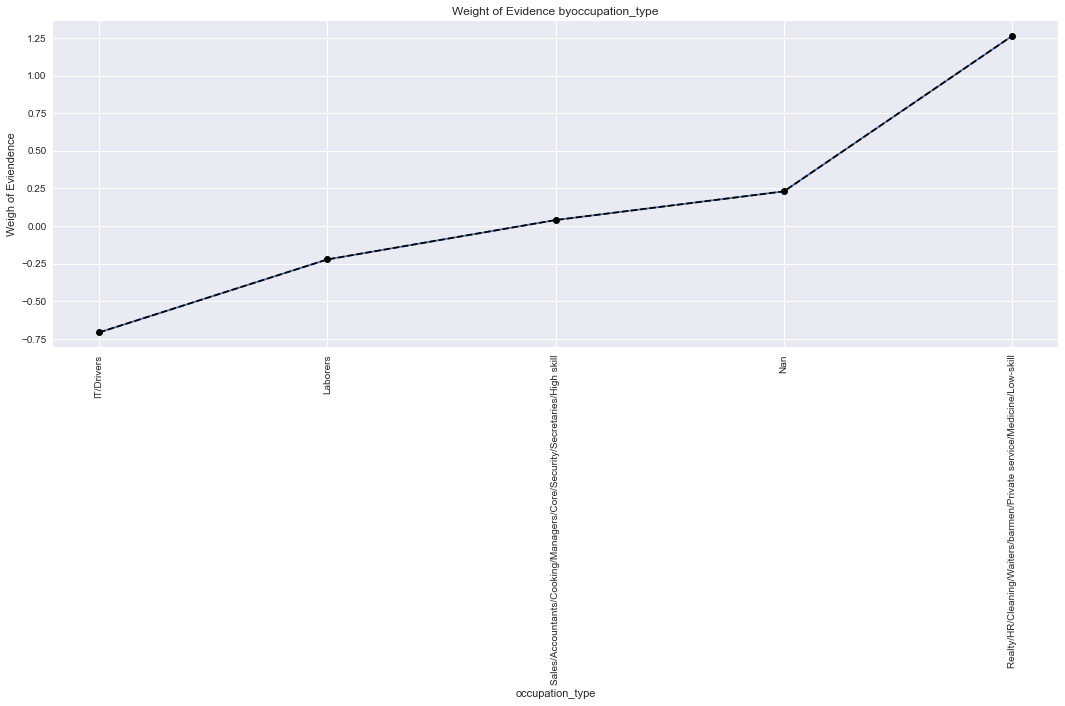

In [77]:
df_features.replace(["Realty agents","HR staff","Cleaning staff","Waiters/barmen staff","Private service staff","Medicine staff","Low-skill Laborers"],"Realty/HR/Cleaning/Waiters/barmen/Private service/Medicine/Low-skill",inplace=True)
df_features.replace(["Sales staff","Accountants","Cooking staff","Managers","Core staff","Security staff",'Secretaries','High skill tech staff'],"Sales/Accountants/Cooking/Managers/Core/Security/Secretaries/High skill",inplace=True)
df_features.replace(['IT staff','Drivers'],"IT/Drivers",inplace=True)

df_temp= woe_discrete(df_features,'occupation_type',df_targets)
display(df_temp)
plot_by_woe(df_temp,90)

# store woe
woe = woe.append(store_woe(df_temp))

## 4.3 Preprocessing Continuous Variables

### Define fuction

In [78]:
def woe_continuous(df,discrete_variable_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variable_name],good_bad_variable_df],axis =1)
    df = pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0],'n_obs','prop_good']
    df['prop_n_obs'] = df['n_obs']/df['n_obs'].sum()
    df['n_good'] = df['prop_good']*df['n_obs']
    df['n_bad'] = (1- df['prop_good'])*df['n_obs']
    df["prop_n_good"] = df['n_good'] / df['n_good'].sum()
    df["prop_n_bad"]= df['n_bad'] / df['n_good'].sum()
    df['WoE'] = np.log(df["prop_n_good"]/df["prop_n_bad"])
    df["IV"]= (df["prop_n_good"]-df["prop_n_bad"])*df["WoE"]
    df["IV"] = df["IV"].sum()
    return df

#"age","working_yr","income_amount"

### 4.3. 1 working_yr

/Users/song/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,working_yr_q,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.043, 2.867]",7914,0.611322,0.323483,4838.0,3076.0,0.392759,0.249716,0.452871,inf
1,"(2.867, 5.733]",6106,0.503767,0.249581,3076.0,3030.0,0.249716,0.245981,0.015067,inf
2,"(5.733, 8.6]",4652,0.482158,0.190149,2243.0,2409.0,0.182091,0.195567,-0.071397,inf
3,"(8.6, 11.467]",2470,0.471255,0.100961,1164.0,1306.0,0.094496,0.106024,-0.115107,inf
4,"(11.467, 14.333]",1240,0.327419,0.050685,406.0,834.0,0.032960,0.067706,-0.719880,inf
5,"(14.333, 17.2]",658,0.302432,0.026896,199.0,459.0,0.016155,0.037263,-0.835745,inf
6,"(17.2, 20.067]",615,0.367480,0.025138,226.0,389.0,0.018347,0.031580,-0.543044,inf
7,"(20.067, 22.933]",245,0.355102,0.010014,87.0,158.0,0.007063,0.012827,-0.596687,inf
8,"(22.933, 25.8]",238,0.151261,0.009728,36.0,202.0,0.002923,0.016399,-1.724749,inf
9,"(25.8, 28.667]",137,0.131387,0.005600,18.0,119.0,0.001461,0.009661,-1.888752,inf


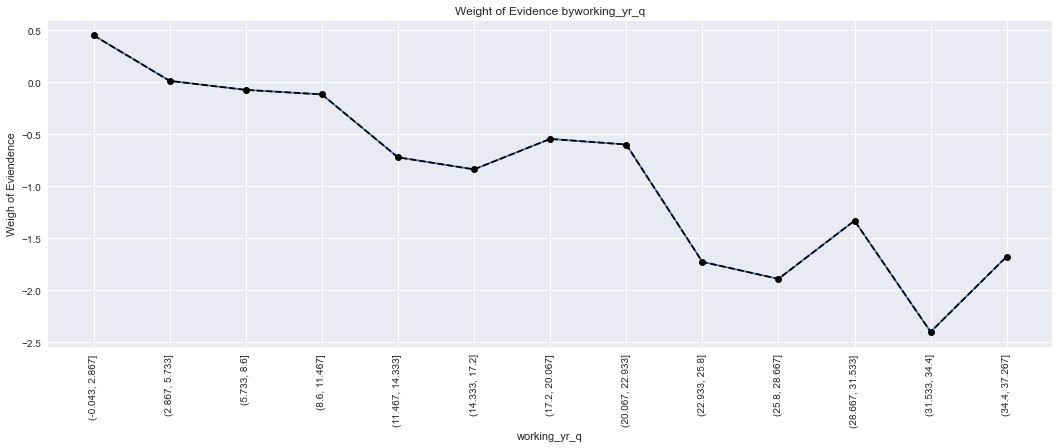

In [79]:
df_features['working_yr_q'] = pd.cut(df_features['working_yr'],15)

df_temp = woe_continuous(df_features,"working_yr_q",df_targets)
display(df_temp)
plot_by_woe(df_temp,90)

In [80]:
### working_yr
df_features['<= 3'] = np.where((df_features['working_yr'] <= 3), '<= 3', "")
df_features['3~11'] = np.where((df_features['working_yr'] > 3) & (df_features['working_yr'] <= 11), '3~11', "")
df_features['11~22'] = np.where((df_features['working_yr'] > 11) & (df_features['working_yr'] <= 22), '11~22', "")
df_features['> 22'] = np.where((df_features['working_yr'] > 22), '>= 22', "")

df_features['working_yr_q'] = df_features['<= 3'] + df_features['3~11'] +df_features['11~22']+df_features['> 22']
df_features.drop(columns =['<= 3', '3~11','11~22','> 22'],inplace =True)

,working_yr_q,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
2,<= 3,9546,0.564111,0.390190,5385.0,4161.0,0.437165,0.337798,0.257862,0.124393
1,3~11,11520,0.508681,0.470877,5860.0,5660.0,0.475727,0.459490,0.034726,0.124393
0,11~22,2824,0.348442,0.115430,984.0,1840.0,0.079883,0.149375,-0.625895,0.124393
3,>= 22,575,0.154783,0.023503,89.0,486.0,0.007225,0.039454,-1.697572,0.124393


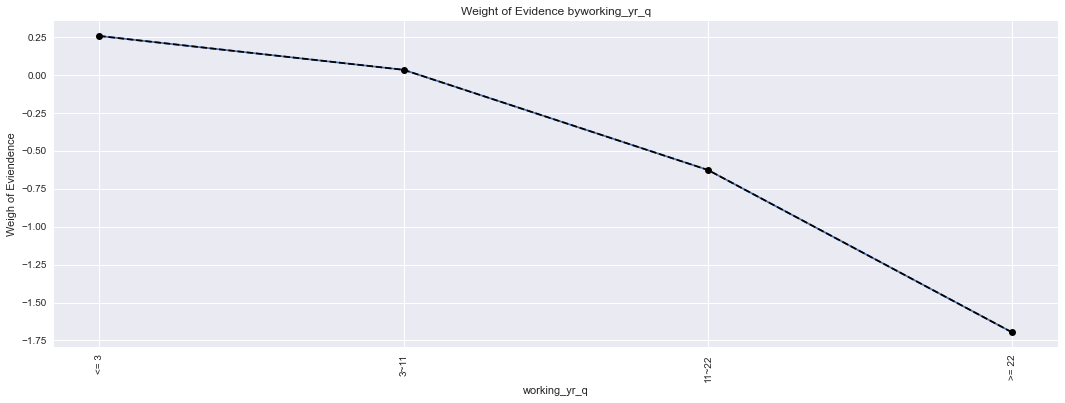

In [81]:
df_temp = woe_continuous(df_features,"working_yr_q",df_targets)
df_temp = df_temp.loc[[2,1,0,3]]
display(df_temp)
plot_by_woe(df_temp,90)

# store woe
woe = woe.append(store_woe(df_temp))

### 4.3.2 age

/Users/song/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,age_q,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(20.954, 23.3]",85,0.141176,0.003474,12.0,73.0,0.000974,0.005926,-1.805553,inf
1,"(23.3, 25.6]",512,0.494141,0.020928,253.0,259.0,0.020539,0.021026,-0.023439,inf
2,"(25.6, 27.9]",1184,0.519426,0.048396,615.0,569.0,0.049927,0.046193,0.077742,inf
3,"(27.9, 30.2]",2795,0.611091,0.114245,1708.0,1087.0,0.138659,0.088245,0.451901,inf
4,"(30.2, 32.5]",1519,0.466754,0.062089,709.0,810.0,0.057558,0.065757,-0.133179,inf
5,"(32.5, 34.8]",2106,0.616809,0.086082,1299.0,807.0,0.105455,0.065514,0.476026,inf
6,"(34.8, 37.1]",2220,0.421171,0.090742,935.0,1285.0,0.075905,0.104319,-0.317967,inf
7,"(37.1, 39.4]",1818,0.488999,0.074310,889.0,929.0,0.072171,0.075418,-0.044012,inf
8,"(39.4, 41.7]",1829,0.476217,0.074760,871.0,958.0,0.070710,0.077772,-0.095206,inf
9,"(41.7, 44.0]",2092,0.408700,0.085510,855.0,1237.0,0.069411,0.100422,-0.369343,inf


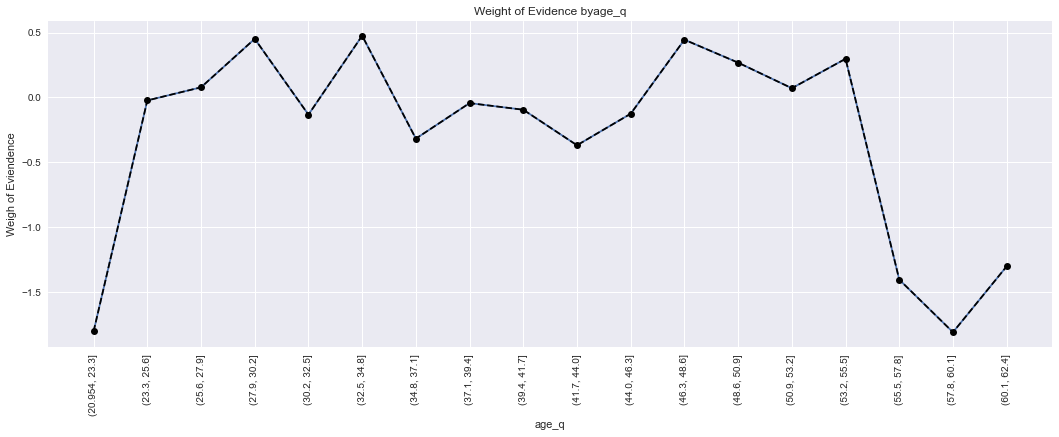

In [82]:
df_features['age_q'] = pd.cut(df_features['age'],20)

df_temp = woe_continuous(df_features,"age_q",df_targets)
display(df_temp)
plot_by_woe(df_temp,90)

In [83]:
### age
df_features['<= 34'] = np.where((df_features['age'] <= 34), '<= 34', "")
df_features['34~54'] = np.where((df_features['age'] > 34) & (df_features['age'] <= 54), '34~54', "")
df_features['>= 54'] = np.where((df_features['age'] > 54), '>= 54', "")

df_features['age_q'] = df_features['<= 34'] + df_features['34~54'] +df_features['>= 54']
df_features.drop(columns =['<= 34', '34~54','>= 54'],inplace =True)

,age_q,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,<= 34,7939,0.545913,0.324504,4334.0,3605.0,0.351843,0.292661,0.184169,0.028896
1,34~54,15003,0.494834,0.613243,7424.0,7579.0,0.602695,0.615278,-0.020663,0.028896
2,>= 54,1523,0.367695,0.062252,560.0,963.0,0.045462,0.078178,-0.542117,0.028896


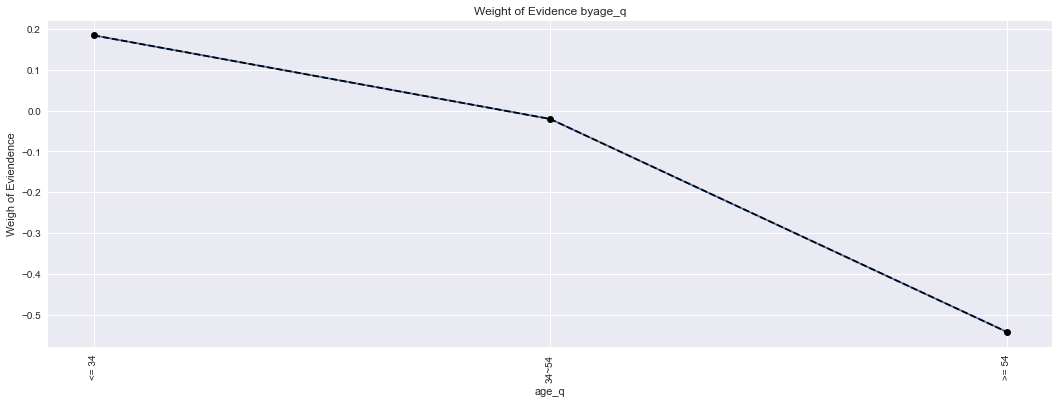

In [84]:
df_temp = woe_continuous(df_features,"age_q",df_targets)
df_temp = df_temp.loc[[1,0,2]]
df_temp.reset_index(inplace=True, drop=True)
display(df_temp)
plot_by_woe(df_temp,90)

# store woe
woe = woe.append(store_woe(df_temp))

### 4.3.3 income_amount

/Users/song/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,income_amount_q,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(25452.0, 57960.0]",107,0.345794,0.004374,37.0,70.0,0.003004,0.005683,-0.637577,inf
1,"(57960.0, 88920.0]",1118,0.511628,0.045698,572.0,546.0,0.046436,0.044325,0.046520,inf
2,"(88920.0, 119880.0]",3711,0.518998,0.151686,1926.0,1785.0,0.156357,0.144910,0.076027,inf
3,"(119880.0, 150840.0]",4250,0.517647,0.173718,2200.0,2050.0,0.178600,0.166423,0.070618,inf
4,"(150840.0, 181800.0]",4956,0.499193,0.202575,2474.0,2482.0,0.200844,0.201494,-0.003228,inf
5,"(181800.0, 212760.0]",2121,0.521924,0.086695,1107.0,1014.0,0.089868,0.082319,0.087751,inf
6,"(212760.0, 243720.0]",2402,0.478768,0.098181,1150.0,1252.0,0.093359,0.101640,-0.084980,inf
7,"(243720.0, 274680.0]",2143,0.470369,0.087595,1008.0,1135.0,0.081831,0.092142,-0.118664,inf
8,"(274680.0, 305640.0]",640,0.607812,0.026160,389.0,251.0,0.031580,0.020377,0.438126,inf
9,"(305640.0, 336600.0]",1181,0.569009,0.048273,672.0,509.0,0.054554,0.041322,0.277810,inf


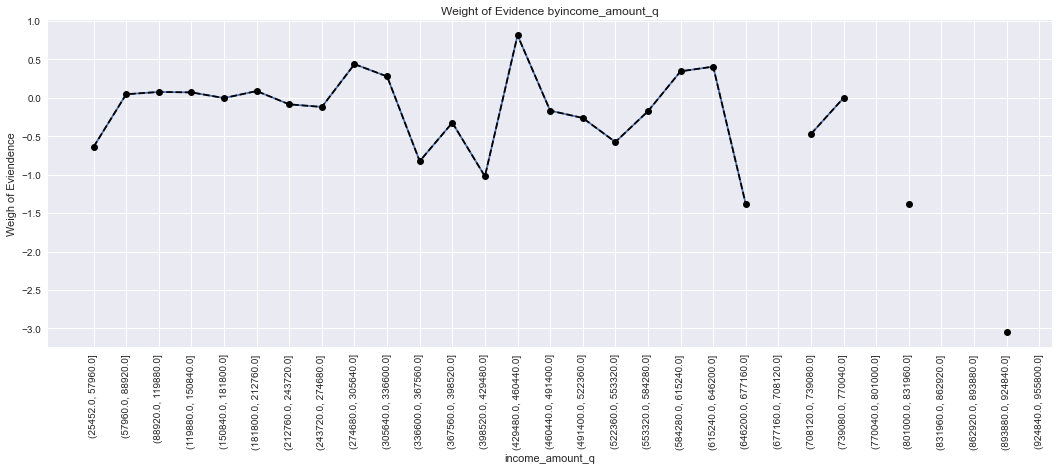

In [85]:
df_features['income_amount_q'] = pd.cut(df_features['income_amount'],50)

df_temp = woe_continuous(df_features,"income_amount_q",df_targets)
display(df_temp)
plot_by_woe(df_temp,90)

In [86]:
df_features['<= 90K'] = np.where((df_features['income_amount'] <= 90000), '<=90K', "")
df_features['90K~150K'] = np.where((df_features['income_amount'] > 90000) & (df_features['income_amount'] <= 150000), '80K~150K', "")
df_features['150K~180K'] = np.where((df_features['income_amount'] > 150000) & (df_features['income_amount'] <= 180000), '150K~180K', "")
df_features['>=180K'] = np.where((df_features['income_amount'] > 180000), '>=180K', "")

df_features['income_amount_q'] = df_features['<= 90K'] + df_features['90K~150K']+ df_features['150K~180K'] + df_features['>=180K']
df_features.drop(columns =['<= 90K','90K~150K', '150K~180K','>=180K'],inplace =True)

,income_amount_q,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,<=90K,2398,0.534612,0.098018,1282.0,1116.0,0.104075,0.090599,0.138670,0.002365
1,80K~150K,6786,0.508547,0.277376,3451.0,3335.0,0.280159,0.270742,0.034191,0.002365
2,150K~180K,4958,0.499395,0.202657,2476.0,2482.0,0.201007,0.201494,-0.002420,0.002365
3,>=180K,10323,0.494914,0.421950,5109.0,5214.0,0.414759,0.423283,-0.020344,0.002365


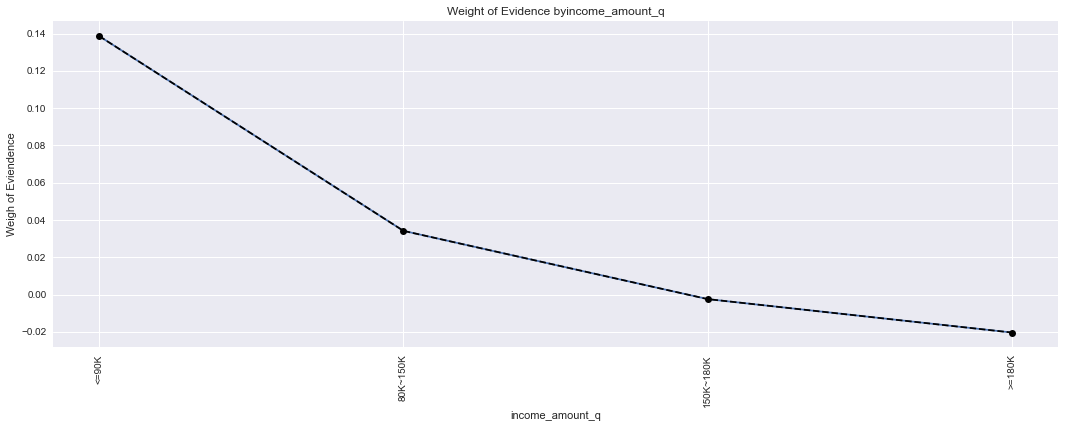

In [87]:
df_temp = woe_continuous(df_features,"income_amount_q",df_targets)
df_temp = df_temp.loc[[2,1,0,3]]
df_temp.reset_index(inplace=True, drop=True)
display(df_temp)
plot_by_woe(df_temp,90)

# store woe
woe = woe.append(store_woe(df_temp))

### Summary of WOE and IV

In [101]:
 display(woe)

 woe.to_csv('./Data/woe.csv')

WoE  \
Features        Value                                                          
car             N                                                  -0.082565   
                Y                                                   0.084479   
realty          Y                                                  -0.033496   
                N                                                   0.021005   
work_phone      0                                                  -0.046773   
                1                                                   0.077438   
phone           0                                                  -0.039221   
                1                                                   0.047447   
email           0                                                  -0.084217   
                1                                                   0.950516   
income_type     Working                                            -0.128380   
                Commercial associate                               -0.034729   
                Student / State servant / Pensioner                 1.492984   
education_type  Secondary / secondary special                      -0.111948   
                others                                              0.195827   
family_status   Widow                                              -0.163072   
                Married                                            -0.084551   
                Single / not married / Civil marriage               0.081086   
                Separated                                           0.990184   
housing_type    House / apartment                                  -0.094136   
                Other                                               1.042180   
children_count  0                                                  -0.142945   
                1                                                   0.184304   
                over 2                                              0.427711   
family_members  <= 2                                               -0.106638   
                3.0                                                 0.150888   
                >= 4                                                0.329123   
occupation_type IT/Drivers                                         -0.706775   
                Laborers                                           -0.221838   
                Sales/Accountants/Cooking/Managers/Core/Securit...  0.039937   
                Nan                                                 0.230381   
                Realty/HR/Cleaning/Waiters/barmen/Private servi...  1.263234   
working_yr_q    <= 3                                                0.257862   
                3~11                                                0.034726   
                11~22                                              -0.625895   
                >= 22                                              -1.697572   
age_q           <= 34                                               0.184169   
                34~54                                              -0.020663   
                >= 54                                              -0.542117   
income_amount_q <=90K                                               0.138670   
                80K~150K                                            0.034191   
                150K~180K                                          -0.002420   
                >=180K                                             -0.020344   

                                                                          IV  
Features        Value                                                         
car             N                                                   0.006993  
                Y                                                   0.006993  
realty          Y                                                   0.000884  
                N                                                   0.000884 

# 5 Mapping woe

Only select features whose IV > 0.01

In [90]:
features = list(woe[woe.IV > 0.01].index.get_level_values(0).unique())
df_features = df_features[features]

In [91]:
for f in list(features):
    values = list(woe.loc[f].index.values)
    for i in range(len(values)):
        df_features.replace({f:{values[i]:woe.loc[(f,values[i])]["WoE"]}},inplace=True)

In [92]:
# store data
df_features.to_csv('./Data/X_train.csv', index=False)
df_targets.to_csv('./Data/y_train.csv', index=False)
#df_features.to_csv('./Data/X_test.csv', index=False)
#df_targets.to_csv('./Data/y_test.csv', index=False)